In [1]:
""" 
manifold for strokes.
clustering
analysis of changes in cluster memebrship with learning.

### [part of this moved]
All analysis moved to:
devo_strokemanifold_analysis_040321

SO:
what remains here is scratch work for training.

"""


' \nmanifold for strokes.\nclustering\nanalysis of changes in cluster memebrship with learning.\n\n### [part of this moved]\nAll analysis moved to:\ndevo_strokemanifold_analysis_040321\n\nSO:\n'

In [17]:
%load_ext autoreload
%autoreload 2

%cd ..

from tools.utils import * 
from tools.plots import *
from tools.analy import *
from tools.calc import *
from tools.analyplot import *
from tools.preprocess import *
from tools.dayanalysis import *
from analysis.strok import *
from analysis.line2 import *
from analysis.probedatTaskmodel import *
from pythonlib.drawmodel.analysis import *
from pythonlib.tools.stroketools import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/data1/code/python/drawmonkey
NOTE: need to not overwrite strokes_all_task, because then the orders saved will stop being accurate. Modify


In [18]:
from analysis.strok import *

## SCRATCH

### Testing out distance metrixs for strokes

In [ ]:
# interpolate all strokes to same length
from pythonlib.tools.stroketools import strokesInterpolate2

strokes = list(SF["strok"].values)

In [ ]:
# -- rescale
strokes_rescale = [rescaleStrokes([s])[0] for s in strokes]
# strokes_rescale = rescaleStrokes(strokes)

# -- interpolate + downsample
npts_space = 50
npts_diff = 25
strokes_rescale = strokesInterpolate2(strokes_rescale, N=["npts", npts_space], base="space")

# -- plot 
inds = random.sample(range(len(strokes_this)), 15)
_plotStroksInGrid([strokes_rescale[i] for i in inds])

In [ ]:
# -- get distance matrix
N = 3
Nbasis = 3

strokes_this = strokes
# strokes_this = strokes_rescale

strokes_this = random.sample(strokes_this, N)
idxs_stroklist_dat = list(range(len(strokes_this)))
if False:
#     idxs_stroklist_dat = list(range(len(strokes_this)))
    idxs_stroklist_basis = random.sample(range(len(strokes_this)), Nbasis)
else:
    idxs_stroklist_basis = idxs_stroklist_dat
    
similarity_matrix = distMatrixStrok(idxs_stroklist_dat, idxs_stroklist_basis, stroklist=strokes_this,
                   normalize_rows=False, normalize_cols_range01=True, ploton=True, 
                                    distancever="euclidian_diffs", rescale_strokes_ver="stretch_to_1")
# similarity_matrix = distMatrixStrok(idxs_stroklist_dat, idxs_stroklist_basis, stroklist=strokes_this,
#                    normalize_rows=False, normalize_cols_range01=True, ploton=True, 
#                                     distancever="euclidian", rescale_strokes_ver="stretch_to_1" )

_plotStroksInGrid(strokes_this)

In [ ]:
# PLOT: condition on one stroke, sort random other strokes by distance.
strokes_this = strokes_rescale

inds = random.sample(range(len(strokes_this)), 15)
strok1 = strokes_this[inds[0]]

# plot the strok being conditioned on
_plotStroksInGrid([strok1]);

for ver in ["euclidian_diffs", "euclidian", "hausdorff_means"]:
    # 1) compute distance matrix
    strokes_compare = [strokes_this[i] for i in inds]
    distances = [distStrok(strok1, s, ver=ver) for s in strokes_compare]

    # sort strokes by distnaces
    vals = [[d, s] for d,s in zip(distances, strokes_compare)]
    vals = sorted(vals, key=lambda x: x[0])
    distances_sorted = [v[0] for v in vals]
    strokes_compare_sorted = [v[1] for v in vals]

    _ = [distStrok(strok1, s, ver=ver, debug=True) for s in strokes_compare_sorted]

    plt.figure()
    plt.plot(range(len(distances_sorted)), distances_sorted, 'ok-')
    plt.title(ver)

    # plot the other storke
    titles = [f"{d:.1f}" for d in distances_sorted]
    _plotStroksInGrid(strokes_compare_sorted, titlelist=titles);
    

    
    

## scratch, developing rescale and velocity based distance

In [ ]:
ind = random.randrange(len(strokes))

In [ ]:
# -- using original velocity code.
strokes_this = [strokes[ind]]
t = strokes_this[0][:,2]
if True:
    strokes_interp = strokesInterpolate2(strokes_this, N = ["npts", 50], base="space")

    # - replace time
    strokes_interp[0][:,2] = np.linspace(t[0], t[-1], 50)
else:
    strokes_interp = strokes_this
# - compute vel
strokes_interp_vel = strokesVelocity(strokes_interp, fs=125, ploton=True)[0]

In [ ]:
#  a quick code for velocity?
strokes_interp_diff = strokesDiffsBtwPts(strokes_interp)
plt.figure()
plt.plot(strokes_interp_diff[0])

# MAIN - PREPARE DATASETS
## Also testing out parsed strokes here

In [ ]:
animal = "Pancho"
exptlist = ["arc2"]
Nbasis = 10
PCAdim = 5
gmm_n_mixtures = list(range(5, 6))
perplist = [15]

# exptlist = ["arc2", "lines5", "shapes3"]
# exptlist = ["arc2", "lines5"]

# strok preprocessing params
rescale_strokes_ver = "stretch_to_1"
distancever = "euclidian_diffs"
npts_space = 50 # for interpolation

# Nbasis = 250
# PCAdim = 5
# gmm_n_mixtures = list(range(5, 27))
# perplist = [15, 25, 45, 55, 65]

# # exptlist = ["arc2", "lines5", "shapes3"]
# exptlist = ["arc2", "lines5"]

# # strok preprocessing params
# rescale_strokes_ver = "stretch_to_1"
# distancever = "euclidian_diffs"
# npts_space = 50 # for interpolation

In [ ]:
# CLUSTERING AND MAINFOLD STUFF MOVED TO "analysis.strok"
# See there for multi-processing verison

from analysis.strok import similarityClustering
similarityClustering(animal, exptlist, 
    Nbasis = Nbasis, PCAdim = PCAdim, gmm_n_mixtures = gmm_n_mixtures,
    perplist = perplist, rescale_strokes_ver = "stretch_to_1", 
    distancever = distancever, npts_space = 50)


## MAIN - VERSION 2, where first get strokedat, then do manifold

In [ ]:
from analysis.strok import *
path_list = [
    "/data2/analyses/database/Pancho-lines5-formodeling-210329_014835",
    "/data2/analyses/database/Pancho-arc2-formodeling-210329_014648",
    "/data2/analyses/database/Pancho-shapes3-formodeling-210329_002448",
    "/data2/analyses/database/Pancho-figures89-formodeling-210329_000418"
]

params = {
    "ver":"dataset",
    "inputs":path_list,
    "strokes_ver":"strokes_parse"
}

# SF = loadStrokeDat(params)

similarityClustering(params)

## first just saving SF for different datasets, then combinig (isnetad of analyzing each SF first)

In [21]:
from analysis.strok import main_cluster_2

main_cluster_2("Red", "strokes_beh_splines")


----------------
Currently loading: /data2/analyses/database/Red-lines5-formodeling-210329_005719
Loaded dataset, size:
5599
Loaded metadat:
{'sketchpad_edges': array([[-327.2, -327.2],
       [ 327.2,  429.6]])}
----------------
Currently loading: /data2/analyses/database/Red-arc2-formodeling-210329_005550
Loaded dataset, size:
4292
Loaded metadat:
{'sketchpad_edges': array([[-327.2, -327.2],
       [ 327.2,  429.6]])}
----------------
Currently loading: /data2/analyses/database/Red-shapes3-formodeling-210329_005200
Loaded dataset, size:
1298
Loaded metadat:
{'sketchpad_edges': array([[-311.84, -224.8 ],
       [ 311.84,  429.6 ]])}
----------------
Currently loading: /data2/analyses/database/Red-figures89-formodeling-210329_005443
Loaded dataset, size:
9683
Loaded metadat:
{'sketchpad_edges': array([[-311.84, -224.8 ],
       [ 311.84,  429.6 ]])}
----
Resetting index
=== CLEANING UP self.Dat ===== 
ORIGINAL: online abort values
assigned_to_wrong_chunk         522
too_far_from_ink   

for this task, expt, epoch, task, this many trials exist: ('LplusL_7-savedset-1-07711', 'arc2', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle2_77-savedset-1-58093', 'arc2', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('LplusL_45-savedset-1-94758', 'arc2', 1, 2)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle_120-savedset-1-66794', 'arc2', 1, 4)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle2_109-savedset-1-28135', 'arc2', 1, 2)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle_136-savedset-1-92314', 'arc2', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_28-savedset-3-53735', 'arc2', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle_17-savedset-1-78719', 'arc2', 1, 4)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle_99-savedset-1-82805', 'arc2', 1, 3)
for this task, expt, epoch, task, 

for this task, expt, epoch, task, this many trials exist: ('mixture1_58-savedset-3-90822', 'figures9', 1, 9)
for this task, expt, epoch, task, this many trials exist: ('mixture2_24-savedset-22-73571', 'figures9', 1, 246)
for this task, expt, epoch, task, this many trials exist: ('mixture1_13-savedset-3-41670', 'figures9', 1, 11)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle_152-savedset-1-04886', 'figures9', 1, 2)
for this task, expt, epoch, task, this many trials exist: ('mixture2_22-savedset-22-73571', 'figures9', 1, 245)
for this task, expt, epoch, task, this many trials exist: ('mixture2_11-savedset-20-71428', 'figures9', 1, 56)
for this task, expt, epoch, task, this many trials exist: ('mixture2_1-savedset-25-77410', 'figures9', 1, 18)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_9-savedset-3-01374', 'figures9', 1, 4)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle2_151-savedset-1-73232', 'figures9', 1, 2

for this task, expt, epoch, task, this many trials exist: ('mixture1_46-savedset-6-63552', 'figures9', 1, 15)
for this task, expt, epoch, task, this many trials exist: ('mixture2_14-savedset-29-76249', 'figures9', 1, 7)
for this task, expt, epoch, task, this many trials exist: ('mixture2_3-savedset-21-62857', 'figures9', 1, 41)
for this task, expt, epoch, task, this many trials exist: ('mixture2_8-savedset-29-76249', 'figures9', 1, 4)
for this task, expt, epoch, task, this many trials exist: ('lineLCircle_120-savedset-1-66794', 'figures9', 1, 9)
for this task, expt, epoch, task, this many trials exist: ('mixture1_31-savedset-6-66733', 'figures9', 1, 15)
for this task, expt, epoch, task, this many trials exist: ('2linePlusL_147-savedset-1-93473', 'figures9', 1, 1)
for this task, expt, epoch, task, this many trials exist: ('LplusL_93-savedset-1-61930', 'figures9', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('mixture1_123-savedset-6-75288', 'figures9', 1, 14)
for this

for this task, expt, epoch, task, this many trials exist: ('2linePlusL_106-savedset-1-33813', 'lines5', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('2linePlusL_193-savedset-1-56042', 'lines5', 1, 1)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_5-savedset-1-17872', 'lines5', 1, 43)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_141-savedset-1-04287', 'lines5', 1, 35)
for this task, expt, epoch, task, this many trials exist: ('LplusL_131-savedset-1-18995', 'lines5', 1, 1)
for this task, expt, epoch, task, this many trials exist: ('3linePlusL_93-savedset-1-02738', 'lines5', 1, 2)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_16-savedset-1-85212', 'lines5', 1, 38)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_58-savedset-1-34870', 'lines5', 1, 46)
for this task, expt, epoch, task, this many trials exist: ('3linePlusL_9-savedset-1-88159', 'lines5', 1, 2)
for this task

for this task, expt, epoch, task, this many trials exist: ('2linePlusL_2-savedset-1-94267', 'lines5', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('LplusL_45-savedset-1-94758', 'lines5', 1, 3)
for this task, expt, epoch, task, this many trials exist: ('3linePlusL_6-savedset-1-03801', 'lines5', 1, 2)
for this task, expt, epoch, task, this many trials exist: ('2linePlusL_9-savedset-1-31420', 'lines5', 1, 1)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_26-savedset-1-38151', 'lines5', 1, 34)
for this task, expt, epoch, task, this many trials exist: ('LplusL_9-savedset-1-82891', 'lines5', 1, 1)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_47-savedset-3-93823', 'lines5', 1, 4)
for this task, expt, epoch, task, this many trials exist: ('LplusL_93-savedset-1-61930', 'lines5', 1, 2)
for this task, expt, epoch, task, this many trials exist: ('LplusL_5-savedset-1-00227', 'lines5', 1, 2)
for this task, expt, epoch, task, thi

for this task, expt, epoch, task, this many trials exist: ('3linePlusL_5-savedset-1-55002', 'lines5', 2, 3)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_76-savedset-1-31186', 'lines5', 2, 59)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_5-savedset-3-84918', 'lines5', 2, 3)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_22-savedset-1-47194', 'lines5', 2, 62)
for this task, expt, epoch, task, this many trials exist: ('LplusL_193-savedset-1-78113', 'lines5', 2, 4)
for this task, expt, epoch, task, this many trials exist: ('LplusL_3-savedset-1-09993', 'lines5', 2, 3)
for this task, expt, epoch, task, this many trials exist: ('2linePlusL_8-savedset-1-94276', 'lines5', 2, 3)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_9-savedset-3-11640', 'lines5', 2, 3)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_25-savedset-1-78640', 'lines5', 2, 30)
for this task, expt, ep

for this task, expt, epoch, task, this many trials exist: ('3linePlusL_2-savedset-1-82223', 'lines5', 2, 4)
for this task, expt, epoch, task, this many trials exist: ('2linePlusL_10-savedset-1-90133', 'lines5', 2, 3)
for this task, expt, epoch, task, this many trials exist: ('2linePlusL_136-savedset-1-88857', 'lines5', 2, 3)
for this task, expt, epoch, task, this many trials exist: ('linePlusLv2_30-savedset-3-95581', 'lines5', 2, 2)
for this task, expt, epoch, task, this many trials exist: ('mixture2_21-savedset-20-71428', 'figures8', 1, 14)
for this task, expt, epoch, task, this many trials exist: ('mixture2_16-savedset-20-71428', 'figures8', 1, 13)
for this task, expt, epoch, task, this many trials exist: ('mixture2_1-savedset-20-71428', 'figures8', 1, 12)
for this task, expt, epoch, task, this many trials exist: ('mixture2_11-savedset-20-71428', 'figures8', 1, 11)
for this task, expt, epoch, task, this many trials exist: ('mixture2_5-savedset-20-71428', 'figures8', 1, 12)
for this t

AssertionError: 

## CONTROL ANALYSIS  using parsed strokes - here code for extracting pre=-extracted parses.

In [1]:
# Load dataset
import pandas as pd
import pickle 
from pythonlib.dataset.dataset import Dataset

animal = "Pancho"
if animal == "Red":
    path_list = [
        "/data2/analyses/database/Red-lines5-formodeling-210329_005719",
        "/data2/analyses/database/Red-arc2-formodeling-210329_005550",
        "/data2/analyses/database/Red-shapes3-formodeling-210329_005200",
        "/data2/analyses/database/Red-figures89-formodeling-210329_005443"
    ]
elif animal=="Pancho":
    path_list = [
        "/data2/analyses/database/Pancho-lines5-formodeling-210329_014835",
        "/data2/analyses/database/Pancho-arc2-formodeling-210329_014648",
        "/data2/analyses/database/Pancho-shapes3-formodeling-210329_002448",
        "/data2/analyses/database/Pancho-figures89-formodeling-210329_000418"
    ]
append_list = None

D = Dataset(path_list, append_list)

# Load accompanying parses


----------------
Currently loading: /data2/analyses/database/Pancho-lines5-formodeling-210329_014835
Loaded dataset, size:
6949
Loaded metadat:
{'sketchpad_edges': array([[-327.2, -327.2],
       [ 327.2,  429.6]])}
----------------
Currently loading: /data2/analyses/database/Pancho-arc2-formodeling-210329_014648
Loaded dataset, size:
5430
Loaded metadat:
{'sketchpad_edges': array([[-327.2, -327.2],
       [ 327.2,  429.6]])}
----------------
Currently loading: /data2/analyses/database/Pancho-shapes3-formodeling-210329_002448
Loaded dataset, size:
1874
Loaded metadat:
{'sketchpad_edges': array([[-311.84, -224.8 ],
       [ 311.84,  429.6 ]])}
----------------
Currently loading: /data2/analyses/database/Pancho-figures89-formodeling-210329_000418
Loaded dataset, size:
9361
Loaded metadat:
{'sketchpad_edges': array([[-311.84, -224.8 ],
       [ 311.84,  429.6 ]])}
----
Resetting index
=== CLEANING UP self.Dat ===== 
ORIGINAL: online abort values
assigned_to_wrong_chunk         798
too_far

In [15]:
D.flattenToStrokdat(strokes_ver="strokes_beh_splines")

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000


,stroknum,strok,row_in_Dataset,Dataset,trial_end_method,online_abort,task_stagecategory,origin,unique_task_name,animal,...,trialcode,tval,tvalday,which_metadat_idx,shortness,frac_overlap,frac_strokes,posterior,monkey_train_or_test,character
0,0,"[[38.3959, 283.93365], [38.287, 283.31525], [3...",0,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,3line,"[-0.0, 51.19999999999999]",3line_5-1-2256843543,Pancho,...,200921-1-4,0.465716,0.6,0,NaN,NaN,NaN,NaN,train,3line
1,1,"[[32.88203, -163.81525], [32.449753, -163.3602...",0,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,3line,"[-0.0, 51.19999999999999]",3line_5-1-2256843543,Pancho,...,200921-1-4,0.465716,0.6,0,NaN,NaN,NaN,NaN,train,3line
2,0,"[[40.171825, 296.74835], [40.12184, 296.11572]...",1,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,3line,"[-0.0, 51.19999999999999]",3line_5-1-2256843543,Pancho,...,200921-1-6,0.466673,0.6,0,NaN,NaN,NaN,NaN,train,3line
3,1,"[[54.454597, -168.95697], [53.9505, -168.63034...",1,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,3line,"[-0.0, 51.19999999999999]",3line_5-1-2256843543,Pancho,...,200921-1-6,0.466673,0.6,0,NaN,NaN,NaN,NaN,train,3line
4,2,"[[-105.2048, 101.52341], [-105.66212, 101.1194...",1,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,3line,"[-0.0, 51.19999999999999]",3line_5-1-2256843543,Pancho,...,200921-1-6,0.466673,0.6,0,NaN,NaN,NaN,NaN,train,3line
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54271,1,"[[42.878815, 133.94649], [42.590996, 134.4912]...",22488,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,mixture2,"[-0.0, 102.40000000000003]",mixture2_13-savedset-13-62857,Pancho,...,210324-1-750,19.403340,19.6,3,0.85579,0.594488,0.75,0.286793,train,mixture2_13-savedset-13-62857
54272,2,"[[46.85989, 207.76639], [46.80925, 208.40002],...",22488,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,mixture2,"[-0.0, 102.40000000000003]",mixture2_13-savedset-13-62857,Pancho,...,210324-1-750,19.403340,19.6,3,0.85579,0.594488,0.75,0.286793,train,mixture2_13-savedset-13-62857
54273,0,"[[67.97788, 190.76682], [67.345184, 190.66171]...",22489,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,mixture2,"[-0.0, 102.40000000000003]",mixture2_11-savedset-13-62857,Pancho,...,210324-1-751,19.403617,19.6,3,0.82502,0.613462,1.00,0.312037,train,mixture2_11-savedset-13-62857
54274,1,"[[22.985443, 89.53766], [22.895468, 90.1475], ...",22489,<pythonlib.dataset.dataset.Dataset object at 0...,done_but_method_unclear,None,mixture2,"[-0.0, 102.40000000000003]",mixture2_11-savedset-13-62857,Pancho,...,210324-1-751,19.403617,19.6,3,0.82502,0.613462,1.00,0.312037,train,mixture2_11-savedset-13-62857


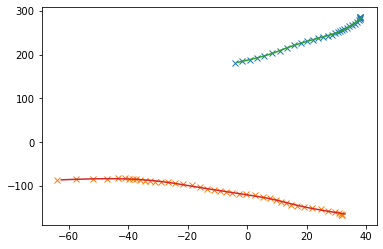

In [14]:
spl = D.Dat["strokes_beh_splines"].values[0]
stk = D.Dat["strokes_beh"].values[0]

import matplotlib.pyplot as plt
plt.figure()
for s in stk:
    plt.plot(s[:, 0], s[:,1], "x")
for s in spl:
    plt.plot(s[:, 0], s[:,1])


In [ ]:
# interpolate beh (to reduce number of pts)
D.interpolateStrokes()

# subsample traisl in a stratified manner to amke sure good represnetaiton
# of all variety of tasks.
D.subsampleTrials()


In [ ]:
# ==== EXTRACT PARSES
D.parsesLoadAndExtract()

In [ ]:
D.parsesChooseSingle()

In [ ]:
for row in D.Dat.iterrows():
    
    print(row[1]["strokes_parse"])
    assert False
    

In [ ]:
# === plot random tasks to look at parsing (GOOD)
n = 10
fig, inds = D.plotMultTrials(n, "strokes_beh", return_idxs=True);
D.plotMultTrials(inds, "strokes_task");
D.plotMultTrials(inds, "parses");
D.plotMultTrials(inds, "parses");
D.plotMultTrials(inds, "parses");

In [ ]:
# For a given trial, overlay beh, task, and parses

import matplotlib.pyplot as plt
ind=random.choice(range(len(D.Dat)))
df = D.Dat.iloc[ind]
strokes_beh = df["strokes_beh"]
strokes_task = df["strokes_task"]
strokes_parse = df["strokes_parse"]

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))

ax= axes.flatten()[0]
plotDatStrokes(strokes_beh, ax, each_stroke_separate=True)

ax= axes.flatten()[1]
plotDatStrokes(strokes_task, ax, each_stroke_separate=True)

ax= axes.flatten()[2]
plotDatStrokes(strokes_parse, ax, each_stroke_separate=True)


from pythonlib.drawmodel.strokedists import distancePos

print(distancePos(strokes_task, strokes_beh))
print(distancePos(strokes_task, strokes_parse))

In [ ]:
# convert to splines
from pythonlib.drawmodel.splines import strokes2splines

strokes = strokes_parse
splines = strokes2splines(strokes)


plt.figure()
for s in strokes:
    plt.plot(s[:,0], s[:,1], "o-")
# plt.figure()
for s in splines:
    plt.plot(s[:,0], s[:,1], "x", alpha=0.5)
plt.figure()
for s in splines:
    plt.plot(s[:,0], s[:,1], "x", alpha=0.5)



In [ ]:
# 2) Add noise so accuracy is similar to behavior.
# plot distribution of accuracies
from pythonlib.drawmodel.strokedists import distancePos

print(distancePos(strokes_task, strokes_beh))
print(distancePos(strokes_task, strokes_parse))

In [ ]:
# 3) match statistics (length,etc)

In [ ]:
### TESTING PARSING
from pythonlib.dataset.dataset import Dataset
from pythonlib.drawmodel.parsing import *
import numpy as np

# For each row, parse its task
image_WH = 105
origin = torch.tensor([image_WH/2, -(0.45*image_WH)])
score_fn = lambda parses: score_function(parses, ver="travel_from_orig", 
                                         normalization="negative", use_torch=True, 
                                        origin=origin)

parses, log_probs = get_parses_from_strokes(strokes_task, 450, 
                                            score_fn = score_fn,
#                                           use_extra_junctions=use_extra_junctions, 
#                                             plot=False, 
#                                             return_in_strokes_coords=return_in_strokes_coords, 
#                                             k=kparses, configs_per = params_parse["configs_per"],
#                                            trials_per = params_parse["trials_per"],
#                                            max_ntrials = params_parse["max_ntrials"],
#                                            max_nstroke = params_parse["max_nstroke"],
#                                            max_nwalk = params_parse["max_nwalk"],
                                           )


## COMMON MANIFOLD ACROSS DATASETS

#### MOVED TO STROK.PY

In [ ]:

# exptlist = ["arc2", "lines5", "figures89"]
exptlist = ["lines5", "figures", "shapes3"]
animallist = ["Red", "Pancho"]
distancelist = ["euclidian_diffs", "euclidian", "hausdorff_means"]
SDIRMAIN = "/data2/analyses/database/clustering/bysimilarity"
strokesver_list = ["beh", "parse"]
rescale = "stretch_to_1"
overwrite = False
dry_run=True

import glob
SDIR_list = []
for anim in animallist:
    for distver in distancelist:
        for sver in strokesver_list:
            dirlist = glob.glob(f"{SDIRMAIN}/*{'*'.join(exptlist)}*-rescale_{rescale}-dist_{distver}-strokes_{sver}/{anim}*")
            for d in dirlist:

                SDIR = d
                print(SDIR)
                if not dry_run:
                    plots(SDIR, overwrite, gmm_n=14, plotGrid=True)
                    
                SDIR_list.append(SDIR)
                
                

In [ ]:
pd.concat(SFall).iloc[50000]

In [ ]:
from pythonlib.tools.pytools import get_size

get_size(SFall)/1000

In [ ]:
get_size(SFall)/1000

In [ ]:
# Load multiple presaved SF, and concatnate.
import pickle
SFall =[]
print("LOADING SF:")
for SDIR in SDIR_list:
    
    path = f"{SDIR}/SF.pkl"
    with open(path, "rb") as f:
        SF = pickle.load(f)

    # add column to map back to original dataset
    SF["path_to_sf"] = path
    
    if "Dataset" in SF.columns:
        del SF["Dataset"]
    print("---")
    print(path)
    SFall.append(SF)
        
    path = f"{SDIR}/SAVEDAT.pkl"
    with open(path, "rb") as f:
        SAVEDAT = pickle.load(f)
    print(SAVEDAT)
        
    

In [ ]:
# concatnate
import pandas as pd
SF = pd.concat(SFall)


SF = SF.reset_index(drop=True)

similarityClusteringFromSF(SF, Nbasis = 3, PCAdim = 2, gmm_n_mixtures = list(range(5, 6)), 
        perplist = [10], rescale_strokes_ver = "stretch_to_1", 
        distancever = "euclidian_diffs", npts_space = 20,
                           savename="combined_parse_beh")


# TO DO - plotting

1. better auto model selection
2. plot more rows for heat map, pca [DONE]
3. shuffle analysis for the "control for stimulus" version of category labels.
4. for each category, how confident are the assignemnets?
5. 

## TAKIGN STOCK - clustering

Best representation:
1. metric: hausdorff (mean,mean, this is crucial to make the distrubtiions gaussian-like. if use max, then will not be.
2. use similarity, scaled bwteen range 0 to 1.

Note, it is possible that will be able to fit with GMM, seems to have clusters,
especialyl when include more variation in primitives.

But clearly is different for testing for the same tasks, across epochs, and clearly falls into more longer/curvy vs. short/straight

Should improve the embeddings, perhaps include also hand-crafted componetns, like length, curvature, etc.

Distance metric:
- Consider also allowing for some variation, kind of like procrustes score. 
Or use splines?

GMM notes:
- diagonal covariance with much works cross val score (ll and bic). comapred to full.

What learn from this:
1. Structure of variation across strokes in repertoire
2. Difference in this structure based on learning (and animal)
3. Non-uniform distribution - evidence for compression. Test this by comparing to null distribution.
4. Growth in primitives over learning (strongest evidence, consider same tasks shown througout lifetime
5. Different primitives 

To do:
1. Construct global embedding, using all models that will be considered: (animals) (task/ground truth) (nn) 
2. Then plot each expt in this space. (e.g., show that animals more clustered than 
3. Include more expriments, inculding more vairation in primtiives (e..g, curves, arcs, etc)
4. Fit GMM within each expt, since part of this could be drift over time. Think of this as: first get some embedding that is global, then do clustering in that space (ie space of PCA of features)
5. GMM tends to split. Somehow constrain to combine more? maybe dont use full covariance?

-- NOTES ON SIMILARITY MATRIX

Longer strokes will tend to be more different from others, even those that are long, perhaps this is fine, 
since in the end this is the "signature" of the stroke

Normalizing to a global max distance. This makes sense, since let's  say a stroke is different from all others, then dont want to help it out by normalizing.

NOTE:
An issue is that long lines can be penalized. How to deal with this? convert to spline?


Technical:
More compact extraction of stroks, compatible easily with probedat, e..g, code to flatten that?
Why min stroke length filter not working?


Other thoughts;
### TO DO:

1) add columns for length, angle, and circularity?

2) Still issue, hausdorff is a bit brittle, if stroke are a bit shifted, etc. Change to either: splines, that distance that allows affine transformation, 

3) Note that this is probably a bigger issue for clustering than for scoring, since scoring is relative.


## Other to do:
1. filter no trials w timeout error. or other indication that I did it.



### TO DO (datset comparison using GMM?)

1. fit model using training data, see how well predict held-out training and test data.


## TAKING STOCK

TO DO:
1. come upw ith general purpose normalization for distances, so that each column is in range of around 0 to 1.
(could also apply this to the clustering code, although not needed since therye can normalize relatrive to entire dataset)


